In [1]:
# Importing Tools
import warnings
import pandas as pd
from numba import jit, cuda
import re
from youtube_comment_downloader import *
import pickle
import numpy as np
from collections import Counter

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from ipywidgets import *
from nltk import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import STOPWORDS
%matplotlib inline

 

# Machine learning packages
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.stem import PorterStemmer
import spacy


 



In [2]:
# Utility
warnings.filterwarnings('ignore')
NUM_OF_THREADS = 6
pd.set_option('display.max_colwidth', None)
dl = nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
en = spacy.load('en_core_web_sm')
stopwords = en.Defaults.stop_words

[nltk_data] Downloading package vader_lexicon to C:\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
train = pd.read_csv("./input/traindata/updated_train_data.csv")

In [4]:
filename = 'logist_model.sav'
model = pickle.load(open(filename, 'rb'))

In [5]:
# Collecting and Cleaning Data
# function optimized to run on gpu 
@jit(target_backend='cuda')
def get_comments(video_url):
    all_data=[]
    downloader = YoutubeCommentDownloader()
    comments = downloader.get_comments_from_url(video_url,sort_by=SORT_BY_POPULAR)
    for comment in list(comments):
        data = dict(comment_id = comment['cid'],
                    comment_text = comment['text'],
                    time = comment['time'],
                    author = comment['author']
                    
                   )
        all_data.append(data)
    return all_data

In [6]:
def apply_regex(corpus):
    corpus = corpus.apply(lambda x: re.sub("\S*\d\S*"," ", x))          # removes numbers and words concatenated with numbers (IE h4ck3r)
    corpus = corpus.apply(lambda x: re.sub("\S*@\S*\s?"," ", x))        # removes emails and mentions (words with @)
    corpus = corpus.apply(lambda x: re.sub("\S*#\S*\s?"," ", x))        # removes hashtags (words with #)
    corpus = corpus.apply(lambda x: re.sub(r'http\S+', ' ', x))         # removes URLs
    corpus = corpus.apply(lambda x: re.sub(r'[^a-zA-Z0-9 ]', ' ',x))    # keeps numbers and letters
    corpus = corpus.apply(lambda x: x.replace(u'\ufffd', '8'))          # replaces the ASCII '�' symbol with '8'
    corpus = corpus.apply(lambda x: re.sub(' +', ' ', x))               # removes multiple spaces
    return corpus

In [7]:
# Sentiment Analysis
def get_pol(df):
    sid = SentimentIntensityAnalyzer()
    df['compound'] = df['comment_text'].apply(lambda comment_text:sid.polarity_scores(str(comment_text))['compound'])
    return df

In [8]:
# function optimized to run on gpu 
@jit(target_backend='cuda')    
def sentiment_score(df):
    df['sentiment'] = ''
    for i,score in enumerate(df['compound']):
        if float(score) > 0:
            df['sentiment'][i] = 'positive'
        elif float(score) == 0.0:
            df['sentiment'][i] = 'neutral'
        else:
            df['sentiment'][i] ='negative'
    return df

In [9]:
# Processing Comments
def process_comments(data,train):
    df = pd.DataFrame(data['sentiment'] +' '+ data['clean_text'])
    df.columns = ['text']
    
    tfid = TfidfVectorizer(lowercase=False,max_features=500)
    tfid_vect = tfid.fit_transform(train['comment_text'])
    tfid_vect = tfid.transform(df['text'])
    
    
    return tfid_vect

In [10]:
# Toxicity Score
def get_predictions(tfid_vect):
    return model.predict(tfid_vect)


In [11]:
# Assigns toxicity score on a scale of 0-5
def get_toxic_score(data):
    df = data[['comment_text','sentiment']]
    df['score'] = data['severe_toxic']+data['obscene']+data['threat']+data['insult']+data['identity_hate']
    return df

In [12]:
def get_results(data,prediction,score = 0,filtered = False):
    data['Toxic_Score'] = prediction.tolist()
    df = data.drop(['clean_text','compound'],axis = 1)
    df['comment_text'].drop_duplicates()
    if filtered:
        reports = df.query('Toxic_Score' == score)
    else:
        reports = df.query('Toxic_Score')
    return reports
        

In [13]:
# Creates Visualizations
# out_graph = widgets.Output()
# @out_graph.capture(clear=True)
def show_distribution(reports):
    word_freq = words_helper(reports)
    sns.set_style("darkgrid")
    toxic_score_dist()
    sentiment_dist()
    word_freq_dist(word_freq)


In [14]:
# out1 = widgets.Output()
# @out1.capture()
def toxic_score_dist():
#     with out1:
        order= range(6)
        ax1 = sns.countplot(x = reports["Toxic_Score"],order=order)
        plt.title('Distribution of Toxic Comments')
        plt.xlabel('Toxicity Rating')
        plt.ylabel('Count')
        for container in ax1.containers:
            plt.bar_label(container)
        plt.show()
     
      

In [15]:
# out2 = widgets.Output()
# @out2.capture()
def sentiment_dist():
#     with out2:
        order = ['negative','neutral','positive']
        sns.countplot(x = reports["sentiment"],order = order)
        plt.title('Distribution Sentiment')
        plt.xlabel('Sentiment')
        plt.ylabel('Count')
        plt.show()

  

In [16]:
# out3 = widgets.Output()
# @out3.capture()
def word_freq_dist(word_freq):
#     with out3:
        sns.barplot(x = word_freq['words'],y=word_freq['count'])
        plt.title('Most Common Words')
        plt.xticks(rotation=45)
#         plt.show()


In [17]:
# Driver
def load_comments(btn):
    video_url = url.value
    global data
    global reports
    score = 0
    filtered = False
    comments = get_comments(video_url)
    data = pd.DataFrame(comments)
    data.drop_duplicates
    data = get_pol(data)
    data = sentiment_score(data)
    data['clean_text'] = apply_regex(data['comment_text'])
    vect = process_comments(data,train)
    prediction = get_predictions(vect)
    reports = get_results(data,prediction,score,filtered)
    show_distribution(reports)


In [18]:
def extreme_toxic(btn5):
    # Report Comments with a Toxic Score of 5
    report5 = data.drop(['compound','clean_text'],axis = 1)
    report5 = data[data['Toxic_Score'] == 5]
    report5.style.set_caption("Toxic Score:5 Reccomendation:Report Comments")
    display(report5)


In [19]:
# Cleans text for visualizations
def words_helper(data):
    for word in STOPWORDS:
        if word not in stopwords:
            stopwords.add(word)
    stopwords.add('that')
    stopwords.add('this')
    stopwords.update
    
    data['clean_text'] = data['comment_text'].str.replace("[^a-zA-Z#]", " ")
    data['clean_text'] = data['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
    all_words = ' '.join([text for text in data['clean_text'] if text not in stopwords])    
    
    cnt = Counter()

    wordlist = all_words.split(' ')

    for word in wordlist:
        cnt[word] += 1
        
    word_freq = pd.DataFrame(cnt.most_common(11),
                             columns=['words', 'count'])
    return word_freq



In [21]:
# Gets URL from user
global url
url = widgets.Text(
    value='https://www.youtube.com/watch?v=aibubHq2-C8',
    placeholder='https://www.youtube.com/watch?v=aibubHq2-C8',
    description='Video URL:',
    disabled=False,
    layout=widgets.Layout(height="auto")
)


In [22]:
# Runs reports on click
btn = widgets.Button(
    value = '',
    description='Get Reports',
    disabled=False,
    button_style='',
    layout=widgets.Layout(height="auto")
)
btn.on_click(load_comments)


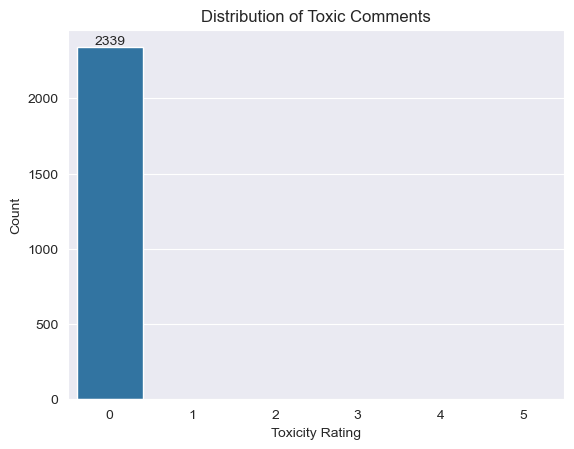

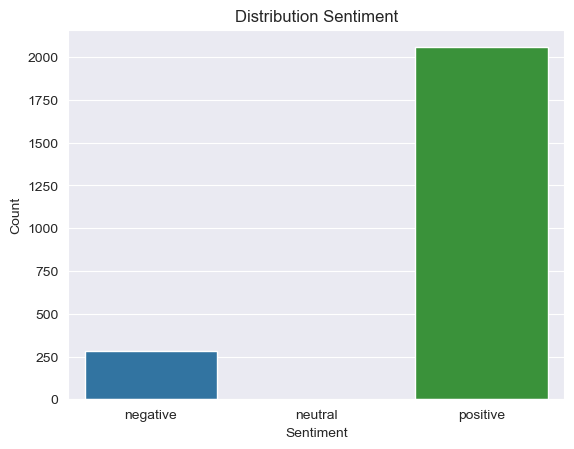

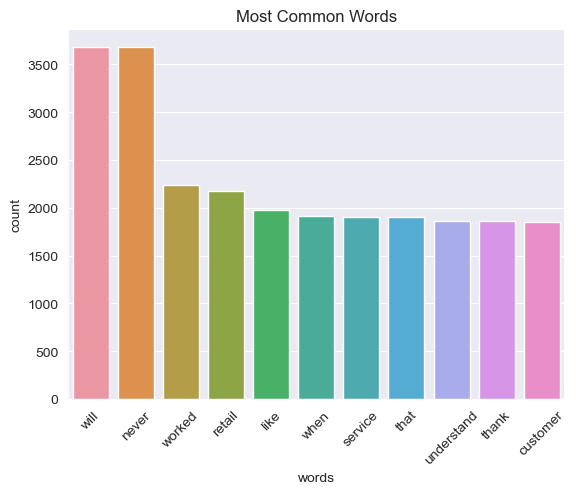

In [23]:
widgets.VBox([url,btn])

In [24]:
dropdown_score = widgets.Dropdown(options = [('0. Nontoxic',0), ('1. Very Slightly Toxic',1) ,('2. Slightly Toxic',2),('3. Toxic',3),('4. Severely  Toxic',4),('5. Extremely Toxic',5)])
output_score = widgets.Output()
@output_score.capture(clear=True)
def dropdown_score_eventhandler(change):
    output_score.clear_output()
#     report = data[data.Toxic_Score == change.new]
    with output_score:
        display(data[data.Toxic_Score == change.new])
        
dropdown_score.observe(dropdown_score_eventhandler, names='value')
display(dropdown_score)

Dropdown(options=(('0. Nontoxic', 0), ('1. Very Slightly Toxic', 1), ('2. Slightly Toxic', 2), ('3. Toxic', 3)…

In [25]:
output_score

Output()